In [1]:
import cv2
import argparse
import imutils
import time
import scipy.io
# from sklearn.svm import SVC
import skvideo.io
from sklearn.decomposition import PCA
# from sklearn.manifold import Isomap
# from sklearn.manifold import LocallyLinearEmbedding
from scipy.ndimage import morphology as mp
from skimage.feature import canny
from thundersvm import SVC
from random import sample
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction import image
from random import shuffle
import numpy as np
import matplotlib.pyplot as plt
import mahotas
from imutils.video import VideoStream
from imutils.video import FPS
import os
import pickle
import copy

In [7]:
def playVideo(file,vidname,label):
    (major, minor) = cv2.__version__.split(".")[:2]

    OPENCV_OBJECT_TRACKERS = {
        "csrt": cv2.TrackerCSRT_create,
        "kcf": cv2.TrackerKCF_create,
        "boosting": cv2.TrackerBoosting_create,
        "mil": cv2.TrackerMIL_create,
        "tld": cv2.TrackerTLD_create,
        "medianflow": cv2.TrackerMedianFlow_create,
        "mosse": cv2.TrackerMOSSE_create
    }

    # grab the appropriate object tracker using our dictionary of
    # OpenCV object tracker objects
    tracker = OPENCV_OBJECT_TRACKERS["kcf"]()

    vs = cv2.VideoCapture(file)
    initBB = None
    # initialize the FPS throughput estimator
    fps = None
    
    boxes = {}
    
    # loop over frames from the video stream
    fno = 1
    delay=1
    while True:
        # grab the current frame, then handle if we are using a
        # VideoStream or VideoCapture object
        frame1 = vs.read()
        frame = frame1[1] # if args.get("video", False) else frame1
        # frame = fgbg.apply(frame)

        # check to see if we have reached the end of the stream
        if frame is None:
            break

        # resize the frame (so we can process it faster) and grab the
        # frame dimensions
#         frame = imutils.resize(frame, width=500)
        (H, W) = frame.shape[:2]

        # check to see if we are currently tracking an object
        if initBB is not None:
            # grab the new bounding box coordinates of the object
            (success, box) = tracker.update(frame)

            # check to see if the tracking was a success
            if success:
                (x, y, w, h) = [int(v) for v in box]
                cv2.rectangle(frame, (x, y), (x + w, y + h),
                    (0, 255, 0), 2)
                boxes[fno]=[x,y,x+w,y+h]

            # update the FPS counter
            if fps is not None:
                fps.update()
                fps.stop()

                # initialize the set of information we'll be displaying on
                # the frame
                info = [
                    ("Tracker", "kcf"),
                    ("Success", "Yes" if success else "No"),
                    ("FPS", "{:.2f}".format(fps.fps())),
                ]
                
                if success:
                    delay=5
                else:
                    delay=10

                # loop over the info tuples and draw them on our frame
                for (i, (k, v)) in enumerate(info):
                    text = "{}: {}".format(k, v)
                    cv2.putText(frame, text, (10, H - ((i * 20) + 20)),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 2)
        else:
            initBB = cv2.selectROI(str(label)+":"+vidname, frame, fromCenter=False,
                showCrosshair=True)
            print("Initial BBox: "+str(initBB))

            # start OpenCV object tracker using the supplied bounding box
            # coordinates, then start the FPS throughput estimator as well
            tracker.init(frame, initBB)
            fps = FPS().start()
        # show the output frame
        cv2.imshow(str(label)+":"+vidname, frame)
        key = cv2.waitKey(delay) & 0xFF

        # if the 's' key is selected, we are going to "select" a bounding
        # box to track
        if key == ord("s"):
            # select the bounding box of the object we want to track (make
            # sure you press ENTER or SPACE after selecting the ROI)
            tracker = OPENCV_OBJECT_TRACKERS["kcf"]()
            initBB = None
            # initialize the FPS throughput estimator
            fps = None
            initBB = cv2.selectROI(str(label)+":"+vidname, frame, fromCenter=False,
                showCrosshair=True)
            print("Frame: "+str(fno)+" Selected BBox: "+str(initBB))

            # start OpenCV object tracker using the supplied bounding box
            # coordinates, then start the FPS throughput estimator as well
            tracker.init(frame, initBB)
            fps = FPS().start()

        # if the `q` key was pressed, break from the loop
        elif key == ord("q"):
            break

        fno=fno+1

    #         # if we are using a webcam, release the pointer
    #         if not args.get("video", False):
    #             vs.stop()

    #         # otherwise, release the file pointer
    #         else:

    vs.release()

    # close all windows
    cv2.destroyAllWindows()
    return boxes

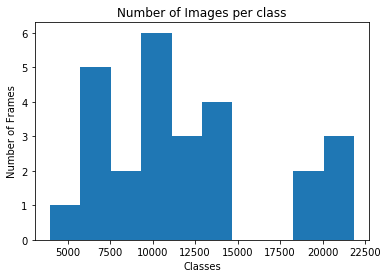

In [42]:
res1=[]
class_list = [132,134,135,147,16,17,2,20,21,22,23,25,36,52,53,54,55,56,57,59,61,64,65,66,67,69]
for i in class_list:
    f = open(basePath+str(i)+"/bbox.pkl","rb")
    boxes = pickle.load(f)
    f.close()
    res=[]
    for file in boxes.keys():
        res.append(len(boxes[file]))
    res1.append(sum(res))
# plt.bar(class_list,res1)
plt.hist(res1)
plt.xlabel('Classes')
plt.ylabel('Number of Frames')
plt.title('Number of Images per class')
# plt.xticks(res1,class_list)
plt.show()

In [41]:
i=0
for x in class_list:
    print(str(x)+":"+str(res1[i]))
    i+=1

132:6526
134:14568
135:21674
147:9690
16:7228
17:3951
2:7954
20:7715
21:12750
22:11711
23:10490
25:7521
36:5791
52:21854
53:11026
54:7203
55:14127
56:13906
57:14183
59:19858
61:19904
64:9944
65:9687
66:10126
67:21299
69:12773


In [8]:
basePath = "../IndianBirds/"
# 132,134,135,147,16,17,2,20,21,22,
# 23,25,36,52,53,54,55,56,57,59,61,
# 64,65,66,67,69,70,71,76,80,81,148,
# 151,158,166,170,172,177,180,188,5,
# 50,51,68,78,84,85,86,9,99,
for i in [177]:
    boxes = {}
    boxes2 = {}
    fullPath = basePath+str(i)+"/"
    allfiles = os.listdir(fullPath)
#     if os.path.exists(fullPath+"bbox-2.pkl"):
#         f = open(fullPath+"bbox-2.pkl","rb")
#         boxes2=pickle.load(f)
#         f.close()
#         boxes=boxes2
    j=0;
#     for j in range(2):
#     for j in range(len(allfiles)):
#         file = allfiles[j];
    for file in allfiles:
#     for file in ["sn5yo9qWaOU.mp4","JL5G9kM64jM.mp4"]:
        if file.endswith(".mp4"):
            fname = file[:-len('.mp4')]
#             if fname in boxes2.keys():
#                 print(fname+" already present")
#                 continue
#             if file in boxes2.keys():
#                 print(file+" already present")
#                 continue
            b = playVideo(fullPath+file,file,i)
            boxes[file] = b
#             j=j+1
#             if (j==2):
#                 break

#     f = open(fullPath+"bbox-2.pkl","wb")
#             f = open(fullPath+"bbox.pkl","wb")
#             pickle.dump(boxes,f)
#             f.close()

Initial BBox: (0, 0, 0, 0)
Frame: 166 Selected BBox: (417, 21, 440, 571)
Frame: 172 Selected BBox: (413, 32, 405, 552)
Initial BBox: (0, 0, 0, 0)
Initial BBox: (0, 0, 0, 0)
Initial BBox: (0, 0, 0, 0)
Initial BBox: (0, 0, 0, 0)
Initial BBox: (0, 0, 0, 0)
Initial BBox: (0, 0, 0, 0)


In [9]:
i=90
basePath = "../IndianBirds/"
boxes = {}
fullPath = basePath+str(i)+"/"
f = open(fullPath+"bbox-2.pkl","rb")
boxes=pickle.load(f)
f.close()

In [11]:
##################### Modify BBoxes #########################
basePath = "../IndianBirds/"

for i in range(90,91):
    boxes = {}
    fullPath = basePath+str(i)+"/"
    allfiles = os.listdir(fullPath)
    
    ## Checking if empty directory ##
    if not allfiles:
        continue
        
    ## Loading existing bounding boxes ##
    f = open(fullPath+"bbox-2.pkl","rb")
    boxes=pickle.load(f)
    f.close()

    ## Modifying particular bounding boxes ##
    filenames = ["2dUItAcsTHI.mp4"]
    for file in filenames:
        b = playVideo(fullPath+file)
        boxes[file] = b
        
    ## Saving modified bounding boxes ##
    f = open(fullPath+"bbox-2.pkl","wb")
    pickle.dump(boxes,f)
    f.close()

Initial BBox: (132, 3, 222, 278)
Frame: 24 Selected BBox: (96, 4, 205, 277)
Frame: 148 Selected BBox: (199, 29, 207, 252)


In [12]:
boxes.keys()

dict_keys(['vRWD1MraURw.mp4', '2dUItAcsTHI.mp4'])

In [5]:
del boxes['content.mp4']

In [8]:
f = open(fullPath+"bbox-2.pkl","wb")
pickle.dump(boxes,f)
f.close()

In [2]:
def showBBoxes(file,boxes,label):
    vs = cv2.VideoCapture(file)
    
    # loop over frames from the video stream
    fno = 1
    
    while True:
        # grab the current frame, then handle if we are using a
        # VideoStream or VideoCapture object
        frame1 = vs.read()
        frame = frame1[1] # if args.get("video", False) else frame1
        # frame = fgbg.apply(frame)

        # check to see if we have reached the end of the stream
        if frame is None:
            break

        # resize the frame (so we can process it faster) and grab the
        # frame dimensions
        frame = imutils.resize(frame, width=500)
        (H, W) = frame.shape[:2]

        # check to see if we are currently tracking an object
        if fno in boxes:
            (x1,y1,x2,y2) = boxes[fno]
            cv2.rectangle(frame, (x1, y1), (x2, y2),
                        (0, 255, 0), 2)

        # show the output frame
        cv2.imshow("Class: "+str(label), frame)
        key = cv2.waitKey(20) & 0xFF

#         # if the `q` key was pressed, break from the loop
        if key == ord("q"):
            break

        fno=fno+1

    vs.release()

    # close all windows
    cv2.destroyAllWindows()
#     data={'X':X,'Y':Y}
#     return data

In [4]:
########################### Show BBoxes ############################
basePath = "../IndianBirds/"

for i in [53]:
    boxes = {}
    fullPath = basePath+str(i)+"/"
    allfiles = os.listdir(fullPath)
    if not allfiles:
        continue
        
    if not os.path.exists(fullPath+"bbox.pkl"):
        continue
    f = open(fullPath+"bbox.pkl","rb")
#     f = open(fullPath+"bbox.pkl","rb")
    boxes=pickle.load(f)
    f.close()
    j=0;
#     for j in range(2):
#     for j in range(len(allfiles)):
#         file = allfiles[j];
#     box = boxes[allfiles[0]][221]
#     for file in allfiles:
#     for file in boxes.keys():
    for file in ["cb23ae0TTbs.mp4"]:
        if file.endswith(".mp4"):
            showBBoxes(fullPath+file,boxes[file],i)
#             j=j+1
#         if (j==2):
#             break
#         boxes[file] = b

In [7]:
boxes['C3wkLDsVUwM.mp4']

{2: [211, 66, 330, 148],
 3: [210, 66, 329, 148],
 4: [209, 66, 328, 148],
 5: [208, 66, 327, 148],
 6: [207, 66, 326, 148],
 7: [206, 64, 325, 146],
 8: [207, 60, 326, 142],
 9: [206, 58, 325, 140],
 10: [207, 62, 326, 144],
 11: [206, 62, 325, 144],
 12: [205, 64, 324, 146],
 13: [202, 62, 321, 144],
 14: [203, 64, 322, 146],
 15: [204, 62, 323, 144],
 16: [205, 64, 324, 146],
 17: [204, 62, 323, 144],
 18: [205, 64, 324, 146],
 19: [204, 62, 323, 144],
 20: [205, 66, 324, 148],
 21: [206, 68, 325, 150],
 22: [205, 66, 324, 148],
 23: [204, 68, 323, 150],
 24: [205, 68, 324, 150],
 25: [204, 70, 323, 152],
 26: [205, 74, 324, 156],
 27: [202, 76, 321, 158],
 28: [201, 76, 320, 158],
 29: [194, 78, 313, 160],
 30: [183, 82, 302, 164],
 31: [174, 84, 293, 166],
 32: [171, 86, 290, 168],
 33: [166, 88, 285, 170],
 34: [161, 88, 280, 170],
 35: [158, 90, 277, 172],
 36: [155, 94, 274, 176],
 37: [148, 96, 267, 178],
 38: [145, 98, 264, 180],
 39: [140, 100, 259, 182],
 40: [137, 102, 256

In [10]:
##################### Modify BBoxes #########################
basePath = "../IndianBirds/"

for i in range(9,10):
    boxes = {}
    fullPath = basePath+str(i)+"/"
    allfiles = os.listdir(fullPath)
    
    ## Checking if empty directory ##
    if not allfiles:
        continue
        
    ## Loading existing bounding boxes ##
    f = open(fullPath+"bbox.pkl","rb")
    boxes=pickle.load(f)
    f.close()

    ## Modifying particular bounding boxes ##
    filenames = ["C3wkLDsVUwM.mp4"]
    for file in filenames:
        b = playVideo(fullPath+file)
        boxes[file] = b
        
    ## Saving modified bounding boxes ##
    f = open(fullPath+"bbox.pkl","wb")
    pickle.dump(boxes,f)
    f.close()

Initial BBox: (201, 58, 134, 108)
Frame: 40 Selected BBox: (98, 78, 181, 149)
Frame: 59 Selected BBox: (27, 115, 211, 158)
Frame: 169 Selected BBox: (51, 116, 217, 161)
Frame: 237 Selected BBox: (28, 53, 242, 219)
Frame: 278 Selected BBox: (42, 81, 244, 200)
Frame: 343 Selected BBox: (101, 44, 247, 231)
Frame: 1554 Selected BBox: (125, 28, 190, 168)
Frame: 1570 Selected BBox: (109, 33, 202, 165)
Frame: 1662 Selected BBox: (101, 56, 248, 216)
Frame: 1680 Selected BBox: (0, 0, 0, 0)
Frame: 1703 Selected BBox: (0, 0, 0, 0)
Frame: 1746 Selected BBox: (110, 40, 353, 241)
Frame: 1772 Selected BBox: (100, 20, 286, 245)
Frame: 1964 Selected BBox: (130, 1, 172, 145)
Frame: 2046 Selected BBox: (0, 0, 0, 0)
Frame: 2522 Selected BBox: (0, 0, 0, 0)
Frame: 2548 Selected BBox: (0, 0, 0, 0)
Frame: 2572 Selected BBox: (145, 47, 144, 134)
Frame: 2639 Selected BBox: (67, 23, 224, 215)
Frame: 2728 Selected BBox: (83, 45, 234, 236)


In [19]:
def recordVideo(file,boxes,label,filename):
    vs = cv2.VideoCapture(file)
    
    # loop over frames from the video stream
    fno = 1
    storepath = 'tracking/'+str(label)+"/"
    if not os.path.exists(storepath):
        os.mkdir(storepath)
#     fname = filename.strip('.mp4')
#     writer = skvideo.io.FFmpegWriter(storepath+fname+"_"+str(nos)+".mp4")
    writer = skvideo.io.FFmpegWriter(storepath+filename)
    
    while True:
        # grab the current frame, then handle if we are using a
        # VideoStream or VideoCapture object
        frame1 = vs.read()
        frame = frame1[1] # if args.get("video", False) else frame1
        # frame = fgbg.apply(frame)

        # check to see if we have reached the end of the stream
        if frame is None:
            break

        # resize the frame (so we can process it faster) and grab the
        # frame dimensions
        frame = imutils.resize(frame, width=500)
        (H, W) = frame.shape[:2]

        # check to see if we are currently tracking an object
        if fno in boxes:
            (x1,y1,x2,y2) = boxes[fno]
            cv2.rectangle(frame, (x1, y1), (x2, y2),
                        (0, 255, 0), 2)

        # show the output frame
        cv2.imshow("Class: "+str(label), frame)
#         [m,n,p] = frame.shape
#         diff = 400 - m
#         top = int(diff/2)
#         bot = diff -top
#         diff = 500 - n
#         left = int(diff/2)
#         right = diff -left
#         padded_img= cv2.copyMakeBorder(frame,top,bot,left,right,cv2.BORDER_CONSTANT,value=[0,0,0])
        padded_img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        writer.writeFrame(padded_img)
        key = cv2.waitKey(20) & 0xFF

#         # if the `q` key was pressed, break from the loop
        if key == ord("q"):
            break

        fno=fno+1

    vs.release()
    writer.close()

    # close all windows
    cv2.destroyAllWindows()
#     data={'X':X,'Y':Y}
#     return data

In [21]:
########################### Record Video ############################
basePath = "../IndianBirds/"

for i in [12,13,16,17,18,20]:
    boxes = {}
    fullPath = basePath+str(i)+"/"
    allfiles = os.listdir(fullPath)
    if not allfiles:
        continue
    f = open(fullPath+"bbox-2.pkl","rb")
#     f = open(fullPath+"bbox.pkl","rb")
    boxes=pickle.load(f)
    f.close()
    j=0;
#     for j in range(2):
#     for j in range(len(allfiles)):
#         file = allfiles[j];
#     box = boxes[allfiles[0]][221]
#     for file in allfiles:
#     for file in ["LfoZ7WTSkoU.mp4", "9IMlpMU2oJM.mp4"]:
    for file in boxes.keys():
        if file.endswith(".mp4"):
            recordVideo(fullPath+file,boxes[file],i,file)
#             j=j+1
#         if (j==2):
#             break
#         boxes[file] = b

In [2]:
def extractFrames(file,label,filename):
    vs = cv2.VideoCapture(file)
    
    # loop over frames from the video stream
    fno = 1
    storepath = 'dataset/'+str(label)+"/"
    if not os.path.exists(storepath):
        os.mkdir(storepath)
    storepath = storepath+filename+'/'
    if not os.path.exists(storepath):
        os.mkdir(storepath)
#     fname = filename.strip('.mp4')
#     writer = skvideo.io.FFmpegWriter(storepath+fname+"_"+str(nos)+".mp4")
#     writer = skvideo.io.FFmpegWriter(storepath+filename)
    
    while True:
        # grab the current frame, then handle if we are using a
        # VideoStream or VideoCapture object
        frame1 = vs.read()
        frame = frame1[1] # if args.get("video", False) else frame1
        # frame = fgbg.apply(frame)

        # check to see if we have reached the end of the stream
        if frame is None:
            break

        # resize the frame (so we can process it faster) and grab the
        # frame dimensions
#         frame = imutils.resize(frame, width=500)
#         (H, W) = frame.shape[:2]

        # check to see if we are currently tracking an object
#         if fno in boxes:
#             (x1,y1,x2,y2) = boxes[fno]
#             cv2.rectangle(frame, (x1, y1), (x2, y2),
#                         (0, 255, 0), 2)

        # show the output frame
        cv2.imshow("Class: "+str(label), frame)
        cv2.imwrite(storepath+str(fno)+'.png',frame)
#         fno += 1
        
#         [m,n,p] = frame.shape
#         diff = 400 - m
#         top = int(diff/2)
#         bot = diff -top
#         diff = 500 - n
#         left = int(diff/2)
#         right = diff -left
#         padded_img= cv2.copyMakeBorder(frame,top,bot,left,right,cv2.BORDER_CONSTANT,value=[0,0,0])
#         padded_img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
#         writer.writeFrame(padded_img)
        key = cv2.waitKey(20) & 0xFF

#         # if the `q` key was pressed, break from the loop
        if key == ord("q"):
            break

        fno=fno+1

    vs.release()
#     writer.close()

    # close all windows
    cv2.destroyAllWindows()
#     data={'X':X,'Y':Y}
#     return data

In [21]:
########################### Extract Frames ############################
basePath = "output/"

for i in [16]:
    boxes = {}
    fullPath = basePath+str(i)+"/"
    allfiles = os.listdir(fullPath)
    if not allfiles:
        continue
#     f = open(fullPath+"bbox-2.pkl","rb")
# #     f = open(fullPath+"bbox.pkl","rb")
#     boxes=pickle.load(f)
#     f.close()
    j=0;
#     for j in range(2):
#     for j in range(len(allfiles)):
#         file = allfiles[j];
#     box = boxes[allfiles[0]][221]
#     for file in allfiles:
    f1="0zfEqtLACyI"
    for file in [f1+"_full.mp4"]:
#     for file in boxes.keys():
        if file.endswith(".mp4"):
            extractFrames(fullPath+file,i,file)
#             j=j+1
#         if (j==2):
#             break
#         boxes[file] = b